**Description**: Analyze simulations data

Powered by Seaborn 

*   [Tutorial](https://www.mygreatlearning.com/blog/seaborn-tutorial/#sh5)
*   [Visualizing distributions](https://seaborn.pydata.org/tutorial/distributions.html)


# Libraries and others

In [1]:
!pip install --upgrade scipy

     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import json
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data

In [5]:
def read_phenotypes(gspace_name):
  phenotypes_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/phenotypes_"+gspace_name+".txt", "r")
  phenotypes = phenotypes_file.read().splitlines()
  phenotypes_file.close()

  return phenotypes

In [6]:
url = "/content/drive/My Drive/Thesis/Code/processedData/"

In [7]:
names = ['four_phen', 'musculus', 'neurospora', 'arabidopsis']

File with the phenotypes at $n$ mutational steps, $n=1, 2, ..., diam(G)$, where $G$ is the genotype space

In [8]:
distance = {}

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[1]+".json", "r")
distance[names[1]] = json.load(distance_file)
distance_file.close()

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[2]+".json", "r")
distance[names[2]] = json.load(distance_file)
distance_file.close()

distance_file = open("/content/drive/My Drive/Thesis/Code/allGraphsReady/distances_"+names[3]+".json", "r")
distance[names[3]] = json.load(distance_file)
distance_file.close()

In [9]:
distance[names[1]].keys()

dict_keys(['6201', '17536', '2669', '16347', '18781', '14488', '16582', '3174', '4166', '4641'])

Parameters

In [10]:
initial_node = {}

initial_node[names[1]] = list(distance[names[1]].keys())[0]
initial_node[names[2]] = list(distance[names[2]].keys())[0]
initial_node[names[3]] = list(distance[names[3]].keys())[0]

In [11]:
distance[names[1]][initial_node[names[1]]].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8'])

In [12]:
print(distance[names[1]][initial_node[names[1]]]['1'])

['Sfpi1', 'Zfp105', 'Gabpa', 'Sox21', 'Sox11', 'Arid5a', 'Zbtb12', 'Sox30', 'Mafb', 'Smad3', 'Setbp1', 'Sox14', 'Arid3a', 'Hoxa3', 'Ehf', 'Elf3', 'Sox12', 'Arid5b', 'Irf4', 'Sox4', 'Irf5', 'Sox13', 'Irf6', 'Irf3', 'Gata5', 'Sox17', 'Sry', 'Sox8', 'Sox5', 'Sox18', 'Tbp', 'Gata3', 'IRC900814', 'Sox7', 'Gata6', 'Irf7', 'Sox15', 'Isgf3g']


Read dataframes with simulations data

In [13]:
df_qw = {}
df_cw = {}
for i in [1,2,3]:
  df_qw[names[i]] = pd.read_csv(url+names[i]+"_qw.csv", index_col=0)
  df_cw[names[i]] = pd.read_csv(url+names[i]+"_cw.csv", index_col=0)

In [14]:
df_cw[names[1]]

,max_simulation_time,total_mutations,simulation_time,tau_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,mutations_Sfpi1,tau_Zic1,mutations_Zic1,tau_Usf2,mutations_Usf2,tau_Srebf1,mutations_Srebf1,tau_Bcl6b,mutations_Bcl6b,tau_E2F3,mutations_E2F3,tau_Klf7,mutations_Klf7,tau_Mitf,mutations_Mitf,tau_Zfp105,mutations_Zfp105,tau_Cebpb,mutations_Cebpb,tau_Gabpa,mutations_Gabpa,tau_Srebf2,mutations_Srebf2,tau_Zic3,mutations_Zic3,tau_Zscan4,mutations_Zscan4,tau_Crem,mutations_Crem,tau_Tcfap4,mutations_Tcfap4,tau_Sox21,mutations_Sox21,tau_Sox11,...,mutations_E2F2,tau_Irf7,mutations_Irf7,tau_Lef1,mutations_Lef1,tau_Mybl1,mutations_Mybl1,tau_Clock,mutations_Clock,tau_Hes5,mutations_Hes5,tau_Tcfec,mutations_Tcfec,tau_Mlxip,mutations_Mlxip,tau_Mtf1,mutations_Mtf1,tau_Zfp410,mutations_Zfp410,tau_Myf6,mutations_Myf6,tau_Hnf4a,mutations_Hnf4a,tau_Tcf1,mutations_Tcf1,tau_Sox15,mutations_Sox15,tau_Tcf4,mutations_Tcf4,tau_Isgf3g,mutations_Isgf3g,tau_Npas2,mutations_Npas2,tau_Foxj1,mutations_Foxj1,tau_Msc,mutations_Msc,tau_Egr1,mutations_Egr1,coverage_rate
0,30000000.0,15,10393.153980,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,...,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,6.273740e+06,2.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.192798e+07,4.0,3.741535e+07,-1.0,3.741535e+07,-1.0,1.810678e+07,6.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,3.741535e+07,-1.0,4.009049e-07
1,30000000.0,14,9631.478758,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,2.580696e+07,11.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,2.580696e+07,11.0,2.580696e+07,...,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,3.467332e+07,-1.0,1.217236e+07,7.0,2.580696e+07,11.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,1.217236e+07,7.0,3.467332e+07,-1.0,3.467332e+07,-1.0,4.037686e-07
2,30000000.0,17,9712.691432,3.496569e+07,-1.0,4.451003e+06,3.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,6.014517e+06,6.0,6.014517e+06,...,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,1.142569e+07,11.0,6.014517e+06,6.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,3.496569e+07,-1.0,4.861909e-07
3,30000000.0,15,9616.655206,3.461996e+07,-1.0,2.487468e+07,12.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,...,-1.0,5.869827e+06,3.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,4.582513e+06,2.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,3.461996e+07,-1.0,4.332761e-07
4,30000000.0,12,8604.483951,3.097614e+07,-1.0,7.2714

# Comparing classical and quantum models

In [15]:
sns.set(font_scale=1.3)

In [16]:
df_results = {}

In [17]:
for i in [1, 2, 3]:
  gspace_name = names[i]

  df_qw[gspace_name]['model'] = ['quantum walk' for i in range(df_qw[gspace_name].shape[0])]
  df_cw[gspace_name]['model'] = ['classical walk' for i in range(df_cw[gspace_name].shape[0])]
  df_results[gspace_name] = pd.concat([df_qw[gspace_name], df_cw[gspace_name]], ignore_index=True)

  df_results[gspace_name] = df_results[gspace_name].astype({"total_mutations": int})
  df_results[gspace_name] = df_results[gspace_name].astype({"simulation_time": float})
  df_results[gspace_name] = df_results[gspace_name].astype({"coverage_rate": float})

In [18]:
df_hitting_times = {} # dataframes for each of the genotype space to analyze hitting times

In [19]:
sns.set(rc = {'figure.figsize':(15,8)})

## Mus musculus

In [20]:
gspace_name = names[1]

In [21]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 3000
Classical walk simulations: 3000


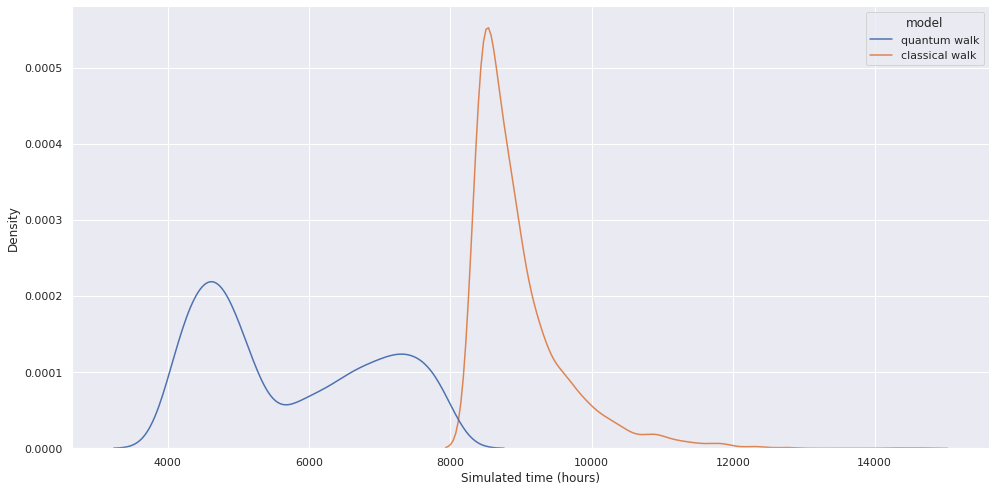

In [22]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

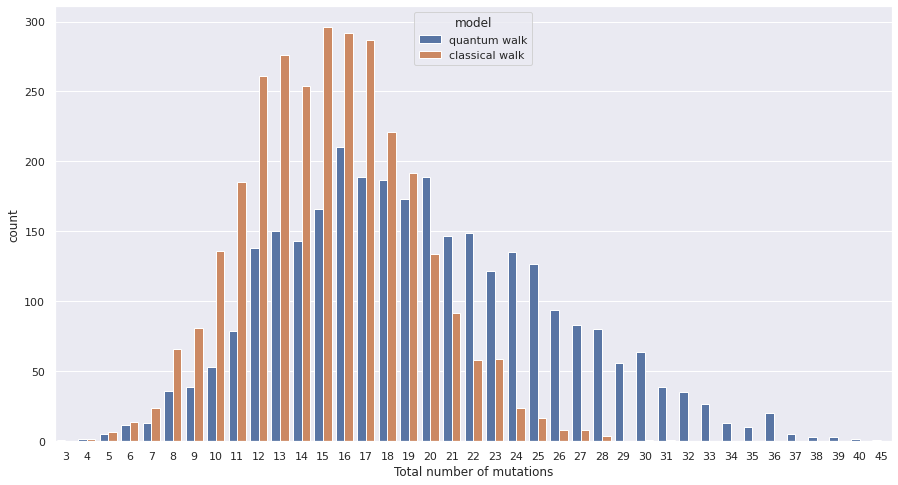

In [23]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [24]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,8962.821600,663.422516,8334.098180,8512.856095,8758.249956,9181.056077,14631.715465
quantum walk,3000.0,5754.554146,1258.826481,4000.255566,4625.648419,5291.736155,6958.733144,7998.828388


In [25]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,15.227667,3.932386,4.0,12.0,15.0,18.0,31.0
quantum walk,3000.0,19.556333,6.293809,3.0,15.0,19.0,24.0,45.0


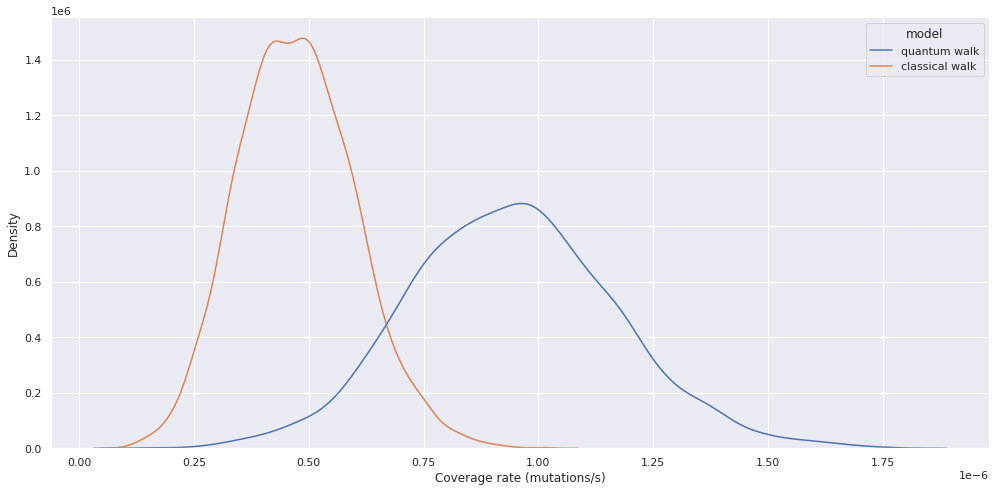

In [26]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [27]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,4.743315e-07,1.268126e-07,1.256621e-07,3.865850e-07,4.696921e-07,5.586352e-07,0.000001
quantum walk,3000.0,9.432422e-07,2.251739e-07,1.681888e-07,7.889782e-07,9.412100e-07,1.089459e-06,0.000002


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [28]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

1.9885714559481016

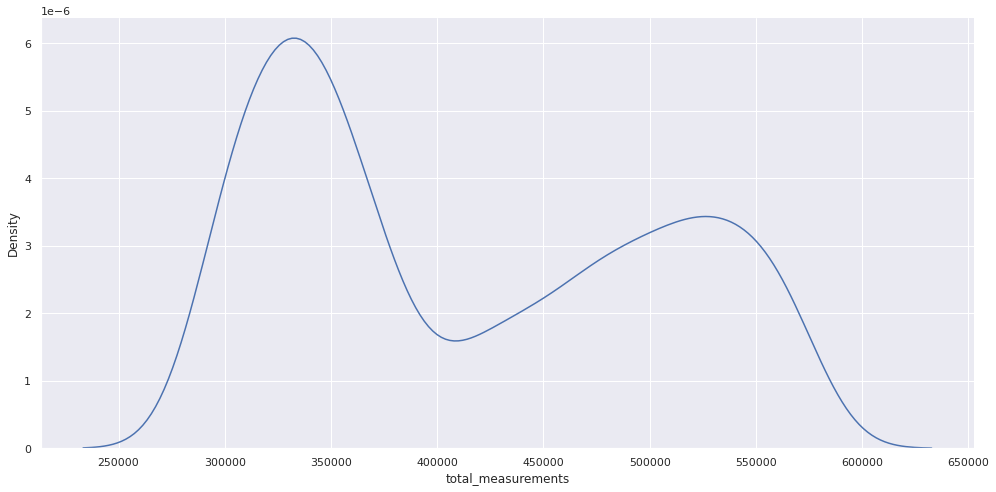

In [29]:
sns.displot(df_qw[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [30]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,3000.0,414338.394,90645.347738,288181.0,333220.0,381334.5,500744.0,577849.0


In [31]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
38/38 were hitted by both walks
38/38 phenotypes had better quantum hitting time
1.4738238145969356 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 1.6632279014430378 

Phenotypes at 2 steps:
85/85 were hitted by both walks
85/85 phenotypes had better quantum hitting time
1.4526912531316674 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.711292049072062 

Phenotypes at 3 steps:
61/61 were hitted by both walks
61/61 phenotypes had better quantum hitting time
1.428175121972912 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.5378271462289734 

Phenotypes at 4 steps:
5/5 were hitted by both walks
5/5 phenotypes had better quantum hitting time
1.417523385743488 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 4.0368182031868 



In [32]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,Sfpi1,7.872262e+06,8.114650
1,classical walk,1,Sfpi1,1.072337e+07,5.678922
2,quantum walk,1,Zfp105,6.864172e+06,6.973936
3,classical walk,1,Zfp105,1.058692e+07,5.613071
4,quantum walk,1,Gabpa,7.283445e+06,7.583468
...,...,...,...,...,...
373,classical walk,4,Jun,2.207544e+07,11.277778
374,quantum walk,4,Terf2,1.512384e+07,15.870588
375,classical walk,4,Terf2,2.001021e+07,11.491803
376,quantum walk,4,Jund,1.300371e+07,13.216216


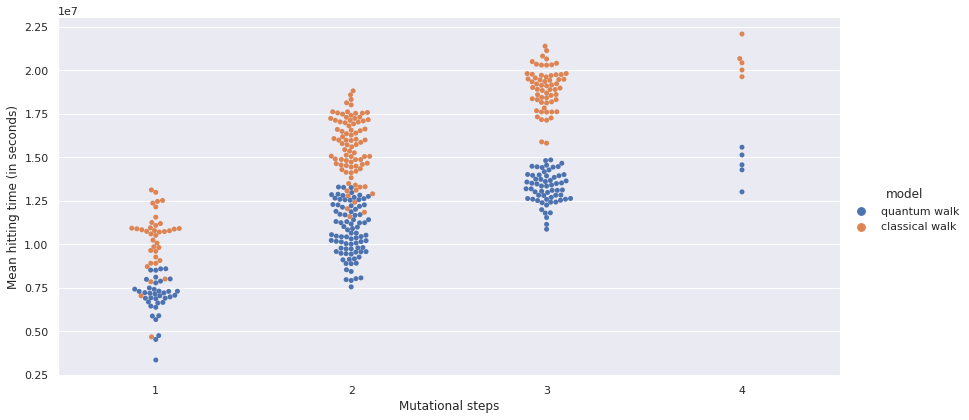

In [33]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

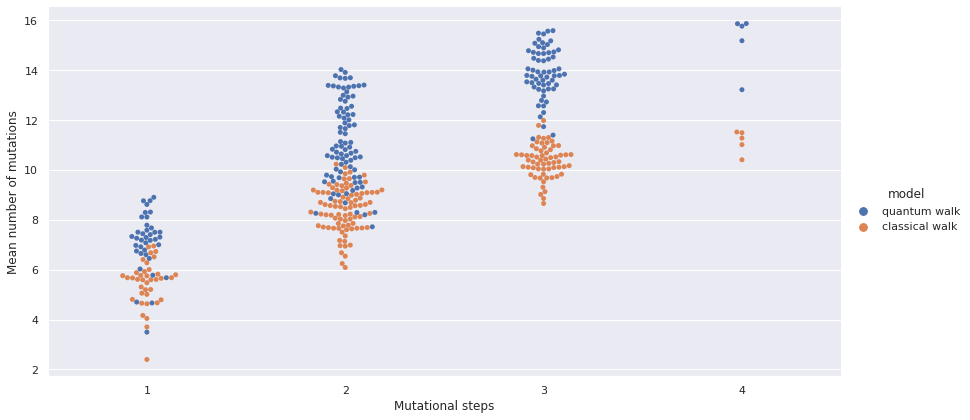

In [34]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [35]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 38.0  1.032256e+07  ...       5.866703   6.950711
               2                 85.0  1.561194e+07  ...       9.101333  10.231270
               3                 61.0  1.894642e+07  ...      10.764228  11.980952
               4                  5.0  2.055807e+07  ...      11.491803  11.521277
quantum walk   1                 38.0  6.985626e+06  ...       7.652439   8.903255
               2                 85.0  1.077084e+07  ...      12.479810  14.024499
               3                 61.0  1.324877e+07  ...      14.701571  15.585366
               4                  5.0  1.450542e+07  ...      15.863636  15.870588

[8 rows x 16 columns]

In [36]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.896315855870036 6.5891370649008865


In [37]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.477685108772458
Step = 2, Speed-up = 1.4494637444567435
Step = 3, Speed-up = 1.4300512536013856
Step = 4, Speed-up = 1.4172679428473793


In [38]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 1.6632279014430367
Step = 2, Difference of mutations = 2.711292049072064
Step = 3, Difference of mutations = 3.537827146228974
Step = 4, Difference of mutations = 4.036818203186799


## Neurospora crassa

In [39]:
gspace_name = names[2]

In [40]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 3000
Classical walk simulations: 3000


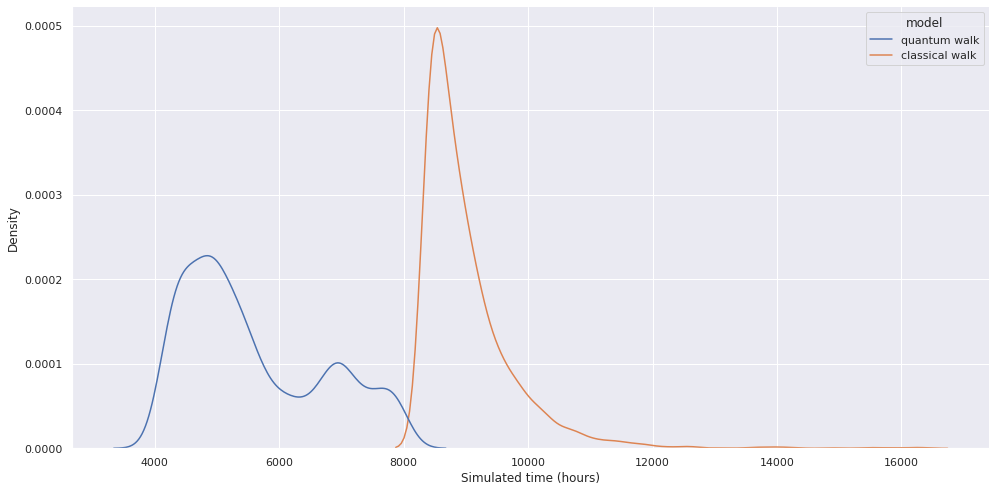

In [41]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', 
            height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

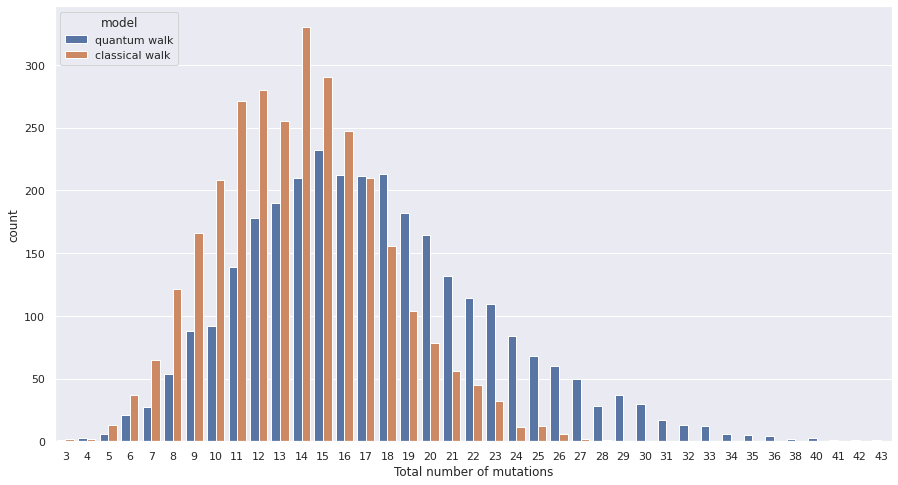

In [42]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [43]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,9011.636851,764.579903,8333.430994,8518.172121,8786.617060,9239.323562,16279.616907
quantum walk,3000.0,5579.975195,1118.925242,4015.528547,4682.289210,5233.321365,6566.047623,7999.645395


In [44]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,13.831333,3.909985,3.0,11.0,14.0,16.0,28.0
quantum walk,3000.0,17.321333,5.728847,3.0,13.0,17.0,21.0,43.0


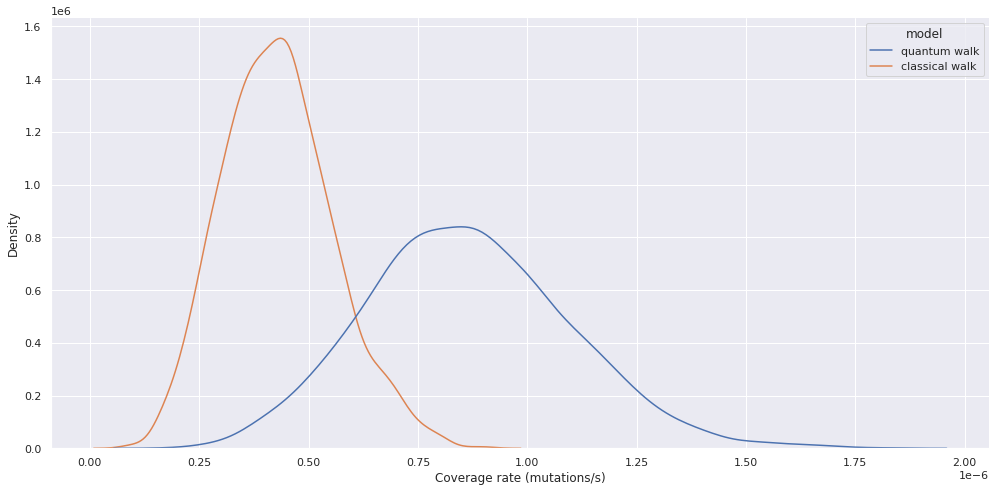

In [45]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [46]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,4.292597e-07,1.263011e-07,8.511954e-08,3.373886e-07,4.253342e-07,5.086609e-07,9.088893e-07
quantum walk,3000.0,8.637058e-07,2.337706e-07,1.959619e-07,7.024576e-07,8.541038e-07,1.013299e-06,1.817437e-06


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [47]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

2.0120822125532145

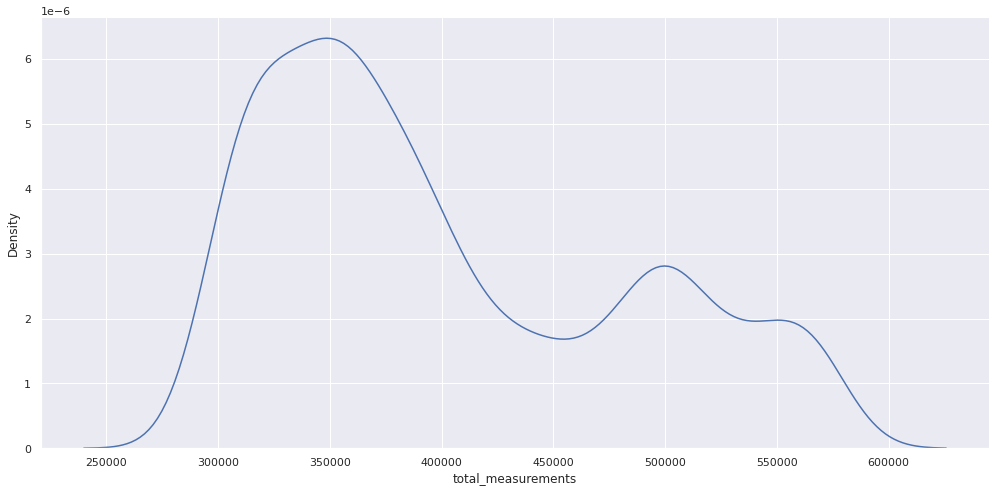

In [48]:
sns.displot(df_qw[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [49]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,3000.0,401761.396667,80548.845534,288660.0,337373.75,376944.5,472876.25,577006.0


In [50]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
29/29 were hitted by both walks
29/29 phenotypes had better quantum hitting time
1.5100921614862797 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 1.474412045904441 

Phenotypes at 2 steps:
46/46 were hitted by both walks
46/46 phenotypes had better quantum hitting time
1.4967858131642502 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.378131642977232 

Phenotypes at 3 steps:
41/41 were hitted by both walks
41/41 phenotypes had better quantum hitting time
1.4836609433095065 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.7700304266244014 

Phenotypes at 4 steps:
1/1 were hitted by both walks
1/1 phenotypes had better quantum hitting time
1.4992941862075353 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.9209744503862147 



In [51]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,NCU02752,6.215800e+06,5.925049
1,classical walk,1,NCU02752,9.228437e+06,4.438178
2,quantum walk,1,NCU06990,8.369905e+06,7.859831
3,classical walk,1,NCU06990,1.201127e+07,5.810365
4,quantum walk,1,NCU06399,6.065463e+06,5.523729
...,...,...,...,...,...
229,classical walk,3,NCU05242,2.058571e+07,11.172932
230,quantum walk,3,NCU07392,1.302303e+07,13.162088
231,classical walk,3,NCU07392,1.947808e+07,10.239130
232,quantum walk,4,NCU06503,1.447856e+07,14.979798


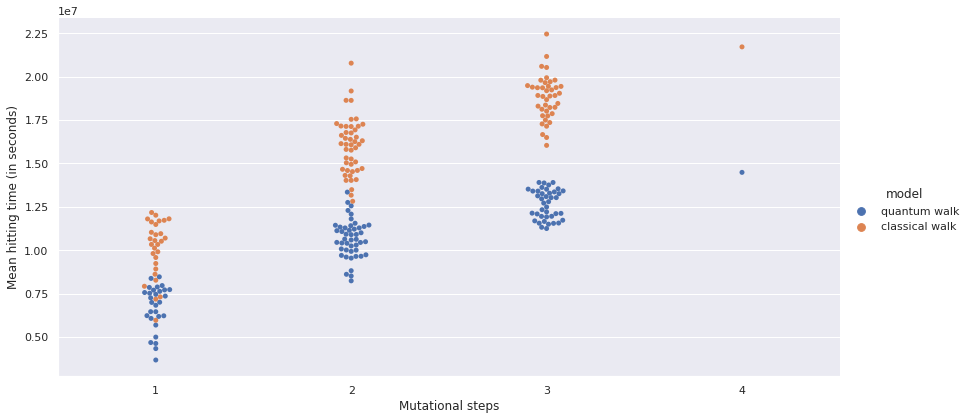

In [52]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

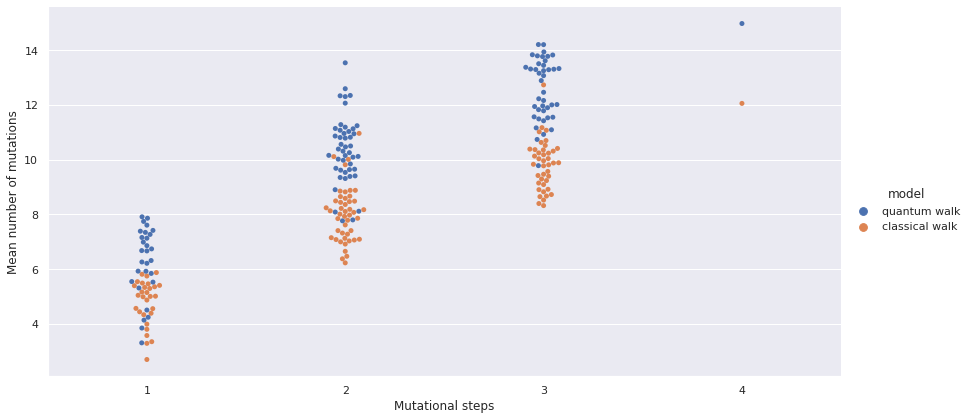

In [53]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [54]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 29.0  1.010195e+07  ...       5.392120   5.872914
               2                 46.0  1.597682e+07  ...       8.490679  10.962963
               3                 41.0  1.879147e+07  ...      10.357143  12.735294
               4                  1.0  2.170762e+07  ...      12.058824  12.058824
quantum walk   1                 29.0  6.715603e+06  ...       7.267840   7.911504
               2                 46.0  1.066650e+07  ...      11.065471  13.542857
               3                 41.0  1.264952e+07  ...      13.450746  14.211382
               4                  1.0  1.447856e+07  ...      14.979798  14.979798

[8 rows x 16 columns]

In [55]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.431059004522826 6.0335257354150444


In [56]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.5042501223139213
Step = 2, Speed-up = 1.497849896195493
Step = 3, Speed-up = 1.4855480362945903
Step = 4, Speed-up = 1.4992941862075355


In [57]:
for step in range(1,5):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 1.474412045904442
Step = 2, Difference of mutations = 2.3781316429772357
Step = 3, Difference of mutations = 2.7700304266243982
Step = 4, Difference of mutations = 2.9209744503862147


## Arabidopsis thaliana

In [58]:
gspace_name = names[3]

In [59]:
print("Quantum walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'quantum walk'].shape[0])
print("Classical walk simulations:", df_results[gspace_name][df_results[gspace_name]['model'] == 'classical walk'].shape[0])

Quantum walk simulations: 3000
Classical walk simulations: 3000


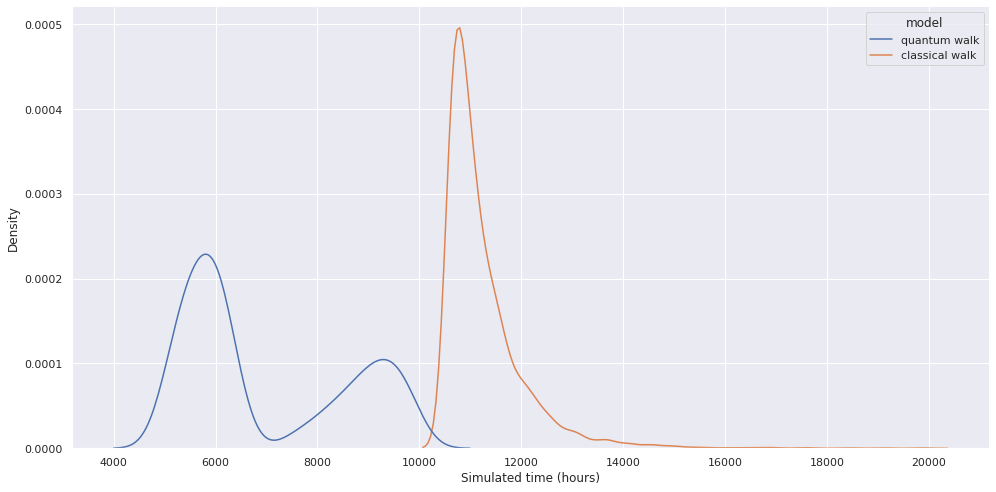

In [60]:
g = sns.displot(df_results[gspace_name], x='simulation_time', hue='model', kind='kde', 
            height=7, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Simulated time (hours)")

Text(0.5, 0, 'Total number of mutations')

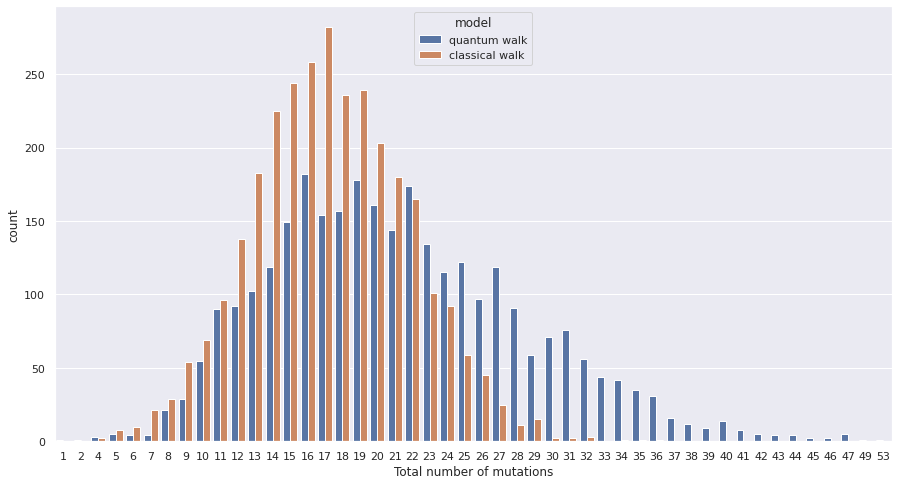

In [61]:
g = sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model")
g.set_xlabel("Total number of mutations")

In [62]:
df_results[gspace_name].groupby(['model'])['simulation_time'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,11251.606848,808.115143,10555.609901,10738.556911,10997.203786,11483.363262,19874.655865
quantum walk,3000.0,6967.881915,1647.519070,5000.242671,5647.687002,6123.535284,8780.376918,9995.648887


In [63]:
df_results[gspace_name].groupby(['model'])['total_mutations'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,17.220667,4.506004,4.0,14.0,17.0,20.0,36.0
quantum walk,3000.0,21.317000,7.321592,1.0,16.0,20.0,26.0,53.0


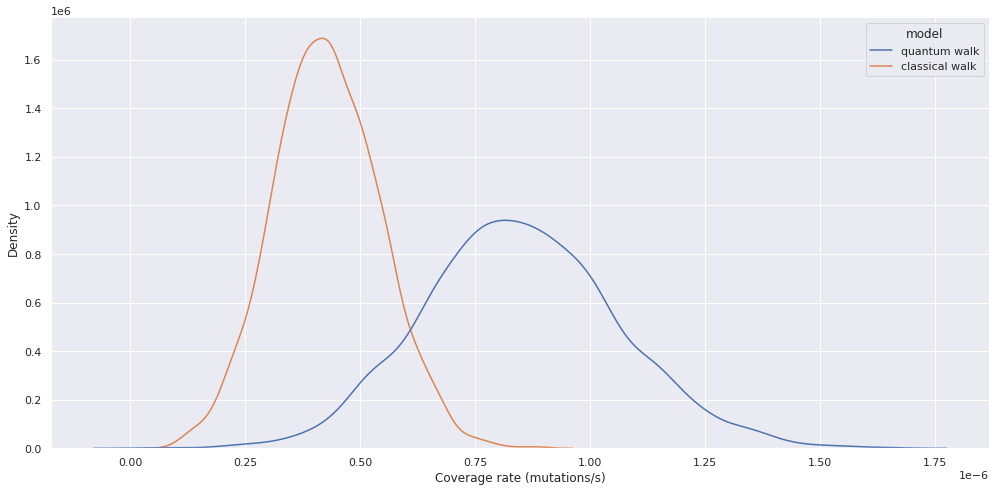

In [64]:
g = sns.displot(df_results[gspace_name], x='coverage_rate', hue='model', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})
g.set_xlabels("Coverage rate (mutations/s)")

In [65]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,3000.0,4.273473e-07,1.157611e-07,9.763700e-08,3.483629e-07,4.232068e-07,5.045076e-07,8.929891e-07
quantum walk,3000.0,8.488275e-07,2.118667e-07,4.902615e-08,7.083682e-07,8.417213e-07,9.850130e-07,1.646511e-06


The coverage rate using CTQW is greater than the coverage rate using CTRW:

In [66]:
df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']/df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']

1.9862711139092482

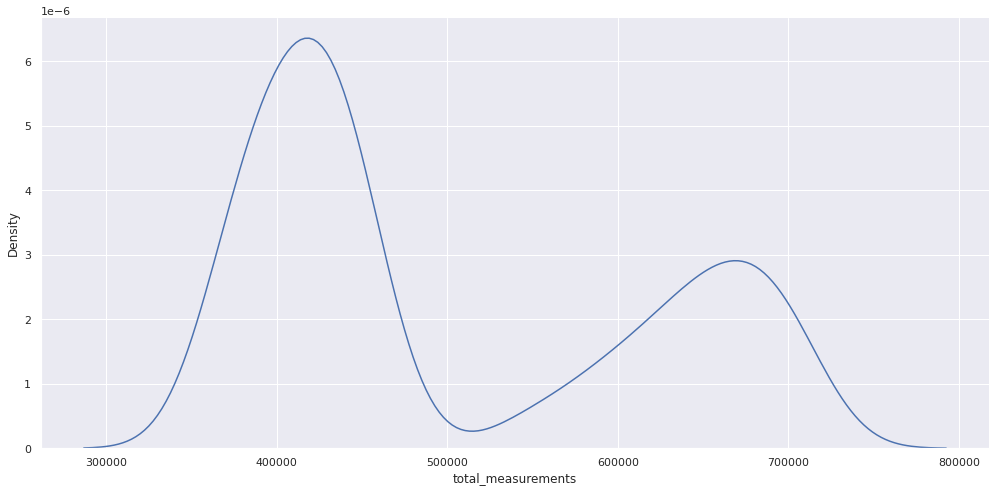

In [67]:
sns.displot(df_qw[gspace_name], x='total_measurements', kind='kde', height=7, aspect=2, 
            facet_kws={"legend_out": False})

In [68]:
df_results[gspace_name].groupby(['model'])['total_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
classical walk,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quantum walk,3000.0,501686.983,118624.90615,358797.0,406739.0,440980.0,631830.75,720708.0


In [69]:
ratios = {}
ratios_better = {}
errors_m = {}
mean_hitting_times = {'model': [], 'step': [], 'phenotype': [], 'mean_hitting_time': [], 'mean_mutations': []}

for step in range(1,7):
  total_phenotypes = len(distance[gspace_name][initial_node[gspace_name]][f'{step}'])
  if total_phenotypes == 0:
    continue
  
  ratios[step] = []
  ratios_better[step] = []
  errors_m[step] = []

  better = 0
  not_hitted = 0

  for phen in distance[gspace_name][initial_node[gspace_name]][f'{step}']:
    mean1 = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()
    mean2 = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'tau_{phen}'].mean()

    mean1_m = df_qw[gspace_name][df_qw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()
    mean2_m = df_cw[gspace_name][df_cw[gspace_name][f'mutations_{phen}'] != -1][f'mutations_{phen}'].mean()

    ratio = mean1/mean2
    error = mean1_m-mean2_m

    if (not math.isnan(mean1)) and (not math.isnan(mean2)): # If both means exists, then the quantum walk and random walk did hit phenotype phen in some simulations
      if ratio < 1:
        better += 1
        ratios_better[step].append(ratio)
      
      ratios[step].append(ratio)
      errors_m[step].append(error)

      # quantum walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('quantum walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean1)
      mean_hitting_times['mean_mutations'].append(mean1_m)

      # classical walk info
      mean_hitting_times['step'].append(step)
      mean_hitting_times['model'].append('classical walk')
      mean_hitting_times['phenotype'].append(phen)
      mean_hitting_times['mean_hitting_time'].append(mean2)
      mean_hitting_times['mean_mutations'].append(mean2_m)

    else:
      if math.isnan(mean1):
        print(f"Phenotype {phen} at {step} steps was not hitted by quantum walk")
      else:
        print(f"Phenotype {phen} at {step} steps was not hitted by classical walk")

      not_hitted += 1

  ratios[step] = np.array(ratios[step])
  ratios_better[step] = np.array(ratios_better[step])
  errors_m[step] = np.array(errors_m[step])

  print(f"Phenotypes at {step} steps:") 
  print(f"{total_phenotypes-not_hitted}/{total_phenotypes} were hitted by both walks")
  print(f"{better}/{total_phenotypes - not_hitted} phenotypes had better quantum hitting time")
  print(f"{1/ratios_better[step].mean()} faster")
  print(f"Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: {errors_m[step].mean()} \n")

Phenotypes at 1 steps:
28/28 were hitted by both walks
28/28 phenotypes had better quantum hitting time
1.5638734854475873 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 1.5330557536210903 

Phenotypes at 2 steps:
77/77 were hitted by both walks
77/77 phenotypes had better quantum hitting time
1.5218234036233718 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 2.6024720778871417 

Phenotypes at 3 steps:
58/58 were hitted by both walks
58/58 phenotypes had better quantum hitting time
1.5046792804469786 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.1437541309827552 

Phenotypes at 4 steps:
40/40 were hitted by both walks
40/40 phenotypes had better quantum hitting time
1.4871567345405252 faster
Mean difference between the number of mutations the CTQW and CTRW took to find phenotypes: 3.510055487937946 

Phenotypes at 5 steps:
13/13 were

In [70]:
df_hitting_times[gspace_name] = pd.DataFrame(mean_hitting_times)
df_hitting_times[gspace_name]

,model,step,phenotype,mean_hitting_time,mean_mutations
0,quantum walk,1,EDT1,8.231389e+06,7.257075
1,classical walk,1,EDT1,1.330070e+07,6.022282
2,quantum walk,1,ATGRP2B,7.911349e+06,7.193076
3,classical walk,1,ATGRP2B,1.200215e+07,5.416309
4,quantum walk,1,GATA8,1.047682e+07,9.476466
...,...,...,...,...,...
427,classical walk,5,AT5G07580,2.802775e+07,14.895833
428,quantum walk,5,AT5G51190,2.088855e+07,20.255556
429,classical walk,5,AT5G51190,2.957335e+07,15.028571
430,quantum walk,5,AT3G23230,1.978398e+07,18.802395


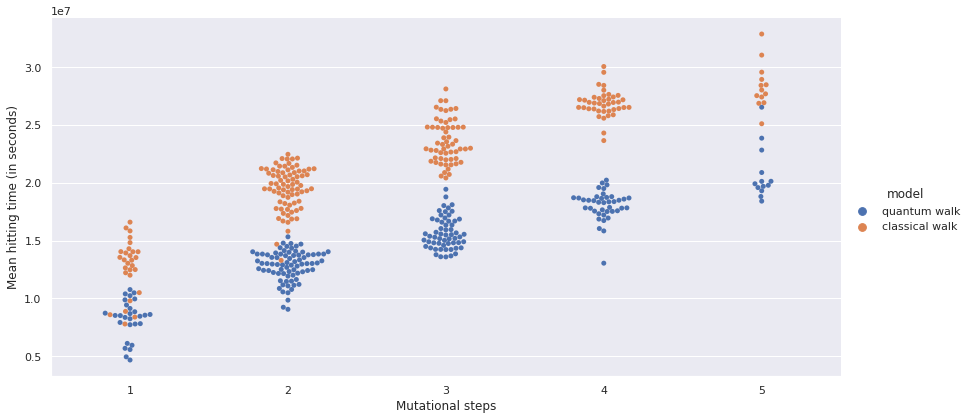

In [71]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_hitting_time', hue='model', kind='swarm', 
            height=6, aspect=2, facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean hitting time (in seconds)")

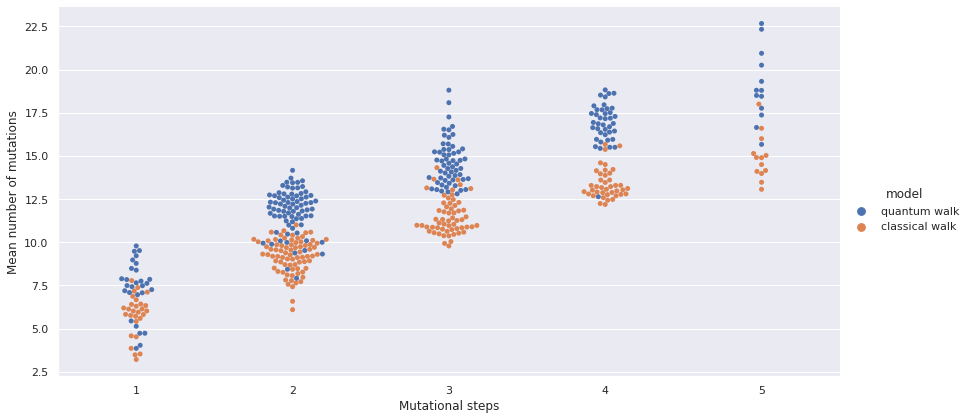

In [72]:
g = sns.catplot(data=df_hitting_times[gspace_name], x="step", y='mean_mutations', hue='model', kind='swarm', height=6, aspect=2,
    facet_kws={"legend_out": False})
g.set_xlabels("Mutational steps")
g.set_ylabels("Mean number of mutations")

In [73]:
df_hitting_times[gspace_name].groupby(['model', 'step'])[['mean_hitting_time', 'mean_mutations']].describe()

mean_hitting_time                ... mean_mutations           
                                count          mean  ...            75%        max
model          step                                  ...                          
classical walk 1                 28.0  1.278229e+07  ...       6.407620   7.778822
               2                 77.0  1.953304e+07  ...       9.943249  11.004992
               3                 58.0  2.360560e+07  ...      12.109986  14.320000
               4                 40.0  2.686477e+07  ...      13.897321  15.666667
               5                 13.0  2.838180e+07  ...      15.140351  18.000000
quantum walk   1                 28.0  8.205050e+06  ...       8.410228   9.787119
               2                 77.0  1.283630e+07  ...      12.686747  14.165414
               3                 58.0  1.567495e+07  ...      15.333500  18.807339
               4                 40.0  1.804998e+07  ...      17.672025  18.823899
               5                 13.0  2.076016e+07  ...      20.255556  22.666667

[10 rows x 16 columns]

In [74]:
mr_cw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['classical walk']
mr_qw = df_results[gspace_name].groupby(['model'])['coverage_rate'].describe()['mean']['quantum walk']

ht_cw = 1.032256e+07
ht_qw = 6.985626e+06

print(mr_cw*ht_cw, mr_qw*ht_qw)

4.411317840944181 5.929591726468799


In [75]:
for step in range(1,6):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_hitting_time'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Speed-up =", mean_cw/mean_qw) 

Step = 1, Speed-up = 1.5578565515408405
Step = 2, Speed-up = 1.521703111272811
Step = 3, Speed-up = 1.5059440596785068
Step = 4, Speed-up = 1.4883542499633569
Step = 5, Speed-up = 1.3671278407007337


In [76]:
for step in range(1,6):
  mean_cw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['classical walk'][step]
  mean_qw = df_hitting_times[gspace_name].groupby(['model', 'step'])['mean_mutations'].describe()['mean']['quantum walk'][step]
  print(f"Step = {step}, Difference of mutations =", mean_qw - mean_cw) 

Step = 1, Difference of mutations = 1.5330557536210918
Step = 2, Difference of mutations = 2.6024720778871355
Step = 3, Difference of mutations = 3.1437541309827566
Step = 4, Difference of mutations = 3.510055487937949
Step = 5, Difference of mutations = 4.127061939697159


# Simulated time and total number of mutations

In [77]:
plt.rcParams.update({"font.size": 11})

In [78]:
subtitles = {
    "time": "Simulated time of genetic evolution",
    "mutations": "Total number of mutations"
}
titles = {
    (1,"time"): "Mus musculus: "+subtitles["time"],
    (1,"mutations"): "Mus musculus: "+subtitles['mutations'],
    (2,"time"): "Neurospora crassa: "+subtitles["time"],
    (2,"mutations"): "Neurospora crassa: "+subtitles['mutations'],
    (3,"time"): "Arabidopsis thalinana: "+subtitles["time"],
    (3,"mutations"): "Arabidopsis thaliana: "+subtitles['mutations'],
    }

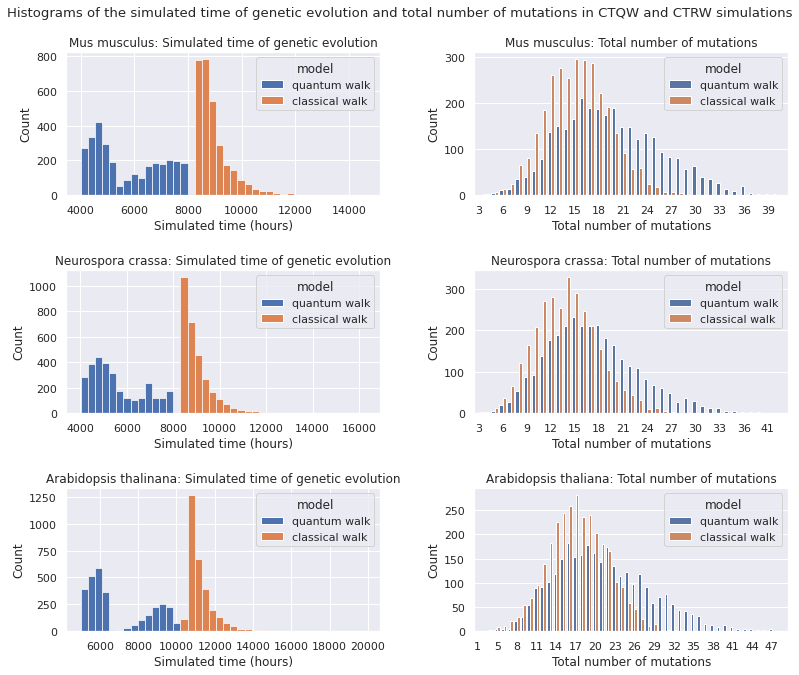

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
fig.suptitle('Histograms of the simulated time of genetic evolution and total number of mutations in CTQW and CTRW simulations')

for i in [1,2,3]:
  gspace_name = names[i]

  axes[i-1][0].set_title(titles[(i,"time")])
  sns.histplot(ax=axes[i-1][0], data=df_results[gspace_name], x='simulation_time', hue='model', bins=40, alpha=1)
  axes[i-1][0].set_xlabel("Simulated time (hours)")
  
  axes[i-1][1].set_title(titles[(i,"mutations")])
  sns.countplot(x="total_mutations", data=df_results[gspace_name], hue="model", ax=axes[i-1][1], alpha=1)
  axes[i-1][1].set_xlabel("Total number of mutations")
  axes[i-1][1].set_ylabel("Count")
  axes[i-1][1].legend(loc='upper right', title='model')

  # format to xtick labels
  for ind, label in enumerate(axes[i-1][1].get_xticklabels()):
    if ind % 3 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.tight_layout(pad=4, w_pad=2, h_pad=2)
plt.savefig("simulations_results.png")

# Coverage rate: (total number of mutations) / (total number of mutations)

In [80]:
df_results[names[1]].head()

,total_measurements,total_mutations,simulation_time,tau_Bhlhe40,N_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,N_Sfpi1,mutations_Sfpi1,tau_Zic1,N_Zic1,mutations_Zic1,tau_Usf2,N_Usf2,mutations_Usf2,tau_Srebf1,N_Srebf1,mutations_Srebf1,tau_Bcl6b,N_Bcl6b,mutations_Bcl6b,tau_E2F3,N_E2F3,mutations_E2F3,tau_Klf7,N_Klf7,mutations_Klf7,tau_Mitf,N_Mitf,mutations_Mitf,tau_Zfp105,N_Zfp105,mutations_Zfp105,tau_Cebpb,N_Cebpb,mutations_Cebpb,tau_Gabpa,N_Gabpa,mutations_Gabpa,tau_Srebf2,...,mutations_Mlxip,tau_Mtf1,N_Mtf1,mutations_Mtf1,tau_Zfp410,N_Zfp410,mutations_Zfp410,tau_Myf6,N_Myf6,mutations_Myf6,tau_Hnf4a,N_Hnf4a,mutations_Hnf4a,tau_Tcf1,N_Tcf1,mutations_Tcf1,tau_Sox15,N_Sox15,mutations_Sox15,tau_Tcf4,N_Tcf4,mutations_Tcf4,tau_Isgf3g,N_Isgf3g,mutations_Isgf3g,tau_Npas2,N_Npas2,mutations_Npas2,tau_Foxj1,N_Foxj1,mutations_Foxj1,tau_Msc,N_Msc,mutations_Msc,tau_Egr1,N_Egr1,mutations_Egr1,coverage_rate,model,max_simulation_time
0,526461.0,19,7307.591245,1.853183e+07,371510.0,15.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,1.374966e+06,27408.0,1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,...,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,1.853183e+07,371510.0,15.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,7.222322e-07,quantum walk,NaN
1,348271.0,18,4846.201181,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,8.501163e+06,169741.0,9.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.502762e+07,299891.0,17.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,...,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,9.609095e+06,191919.0,10.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.142515e+07,228150.0,15.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.031736e-06,quantum walk,NaN
2,492167.0,22,6837.725317,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.434590e+07,286854.0,16.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,4.995887e+06,99952.0,8.0,1.036133e+07,207009.0,14.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,...,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.025534e+06,20710.0,1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.434590e+07,286854.0,16.0,8.937345e-07,quantum walk,NaN
3,429412.0,16,5969.788521,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,...,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,1.554070e+07,310291.0,12.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,1.610451e+07,321688.0,13.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,7.444894e-07,quantum walk,NaN
4,357102.0,17,4960.254567,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,6.688674e+06,133508.0,7.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,...,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,5.437862e+04,1127.0,1.

In [81]:
titles = {
    1: "Mus musculus",
    2: "Neurospora crassa",
    3: "Arabidopsis thaliana"
    }

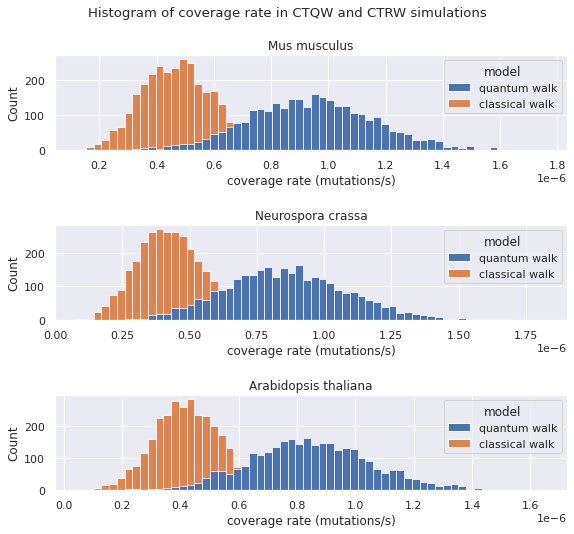

In [82]:
fig, axes = plt.subplots(3, 1, figsize=(9,8))
fig.suptitle('Histogram of coverage rate in CTQW and CTRW simulations')

for i in [1,2,3]:
  gspace_name = names[i]

  axes[i-1].set_title(titles[i])
  sns.histplot(ax=axes[i-1], data=df_results[gspace_name], x='coverage_rate', hue='model', bins=60, alpha=1)
  axes[i-1].set_xlabel("coverage rate (mutations/s)")

plt.tight_layout(pad=4, w_pad=2, h_pad=2)
plt.savefig("coverage_rate.png")

# Mean hitting times

In [83]:
for i in [1,2,3]:
  df_hitting_times[names[2]].to_csv(f"mean_hitting_times_{names[i]}.csv")

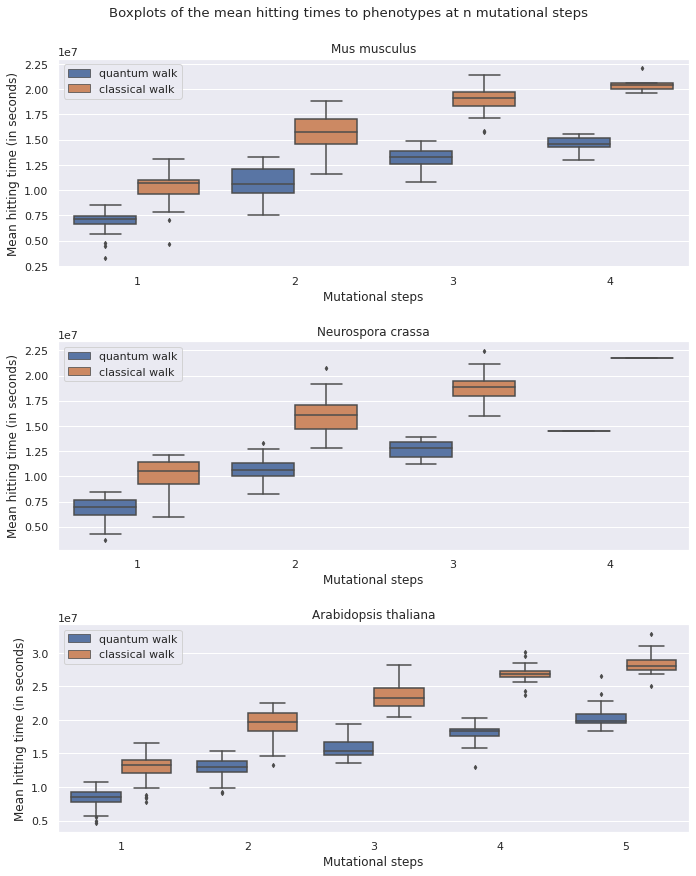

In [84]:
fig, axes = plt.subplots(3,1, figsize=(11,13))
fig.suptitle("Boxplots of the mean hitting times to phenotypes at n mutational steps")

for i in [1,2,3]:
  axes[i-1].set_title(titles[i])
  sns.boxplot(x='step', y="mean_hitting_time", hue="model", data=df_hitting_times[names[i]], ax=axes[i-1], fliersize=3)
  #sns.swarmplot(x="step", y="mean_hitting_time", hue="model", data=df_hitting_times[names[i]], dodge=True, ax=axes[i-1], color="0.25", size=3)
  axes[i-1].set_xlabel("Mutational steps")
  axes[i-1].set_ylabel("Mean hitting time (in seconds)")

  # legend manipulation
  handles, labels = axes[i-1].get_legend_handles_labels()
  axes[i-1].legend(handles[:2], labels[:2])

plt.tight_layout(pad=5, h_pad=2, w_pad=2)
plt.savefig("mean_hitting_times.png")

# Pruebas de hipótesis

In [85]:
df_results[names[1]].head()

,total_measurements,total_mutations,simulation_time,tau_Bhlhe40,N_Bhlhe40,mutations_Bhlhe40,tau_Sfpi1,N_Sfpi1,mutations_Sfpi1,tau_Zic1,N_Zic1,mutations_Zic1,tau_Usf2,N_Usf2,mutations_Usf2,tau_Srebf1,N_Srebf1,mutations_Srebf1,tau_Bcl6b,N_Bcl6b,mutations_Bcl6b,tau_E2F3,N_E2F3,mutations_E2F3,tau_Klf7,N_Klf7,mutations_Klf7,tau_Mitf,N_Mitf,mutations_Mitf,tau_Zfp105,N_Zfp105,mutations_Zfp105,tau_Cebpb,N_Cebpb,mutations_Cebpb,tau_Gabpa,N_Gabpa,mutations_Gabpa,tau_Srebf2,...,mutations_Mlxip,tau_Mtf1,N_Mtf1,mutations_Mtf1,tau_Zfp410,N_Zfp410,mutations_Zfp410,tau_Myf6,N_Myf6,mutations_Myf6,tau_Hnf4a,N_Hnf4a,mutations_Hnf4a,tau_Tcf1,N_Tcf1,mutations_Tcf1,tau_Sox15,N_Sox15,mutations_Sox15,tau_Tcf4,N_Tcf4,mutations_Tcf4,tau_Isgf3g,N_Isgf3g,mutations_Isgf3g,tau_Npas2,N_Npas2,mutations_Npas2,tau_Foxj1,N_Foxj1,mutations_Foxj1,tau_Msc,N_Msc,mutations_Msc,tau_Egr1,N_Egr1,mutations_Egr1,coverage_rate,model,max_simulation_time
0,526461.0,19,7307.591245,1.853183e+07,371510.0,15.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,1.374966e+06,27408.0,1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,...,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,1.853183e+07,371510.0,15.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,2.630733e+07,-1.0,-1.0,7.222322e-07,quantum walk,NaN
1,348271.0,18,4846.201181,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,8.501163e+06,169741.0,9.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.502762e+07,299891.0,17.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,...,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,9.609095e+06,191919.0,10.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.142515e+07,228150.0,15.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.744632e+07,-1.0,-1.0,1.031736e-06,quantum walk,NaN
2,492167.0,22,6837.725317,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.434590e+07,286854.0,16.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,4.995887e+06,99952.0,8.0,1.036133e+07,207009.0,14.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,...,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.025534e+06,20710.0,1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,2.461581e+07,-1.0,-1.0,1.434590e+07,286854.0,16.0,8.937345e-07,quantum walk,NaN
3,429412.0,16,5969.788521,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,...,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,1.554070e+07,310291.0,12.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,1.610451e+07,321688.0,13.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,2.149124e+07,-1.0,-1.0,7.444894e-07,quantum walk,NaN
4,357102.0,17,4960.254567,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,6.688674e+06,133508.0,7.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,...,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,1.785692e+07,-1.0,-1.0,5.437862e+04,1127.0,1.

Separated dataframes with data for phenotypes at n mutational steps from the initial node

In [86]:
df_phen = {} # df_phen[gspace][step][model] : array of hitting times using model to phenotypes at n steps in gspace
for i in [1,2,3]:
  gspace_name = names[i]
  df_phen[gspace_name] = {}

  for step in [1,2,3,4,5]:
    if step == 5 and gspace_name != 'arabidopsis':
      continue

    df_phen[gspace_name][step] = {}

    for model in ['classical walk', 'quantum walk']:
      
      phens_step = distance[gspace_name][initial_node[gspace_name]][f'{step}']
      ht_array = []

      for phen in phens_step:
        ht_array.extend(df_results[gspace_name][(df_results[gspace_name]['mutations_'+phen] > 0) & 
                  (df_results[gspace_name]['model'] == model)]['tau_'+phen].values)

      df_phen[gspace_name][step][model] = np.array(ht_array)

In [87]:
print(df_phen['arabidopsis'][1]['quantum walk'][:10])
print(df_phen['arabidopsis'][1]['classical walk'][:10])

[ 8675456.88791929  1950829.06229604  1575407.21729339  3677261.76662186
  7338665.33472048  3405044.11177536 33740499.29969171 13110457.57015334
    52700.46548875  9406973.87041622]
[12929598.2288974   5687353.27254595  8544290.70285614 36460705.54357225
  4238633.94844271   407234.20019247  1628577.3910497   3789660.93621441
 17560394.67797757 19317614.23194831]


[T test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [88]:
for i in [1,2,3]:
  gspace_name = names[i]
  for step in [1,2,3,4,5]:
    if step == 5 and gspace_name != 'arabidopsis':
      continue

    test = stats.ttest_ind(a=df_phen[gspace_name][step]['quantum walk'], b=df_phen[gspace_name][step]['classical walk'], 
                     equal_var=False, alternative='less')
    print(gspace_name, step, test)

musculus 1 Ttest_indResult(statistic=-62.921605301703906, pvalue=0.0)
musculus 2 Ttest_indResult(statistic=-90.46721935107642, pvalue=0.0)
musculus 3 Ttest_indResult(statistic=-61.00847225444311, pvalue=0.0)
musculus 4 Ttest_indResult(statistic=-12.05645986208045, pvalue=4.768280320993115e-30)
neurospora 1 Ttest_indResult(statistic=-50.524661506966304, pvalue=0.0)
neurospora 2 Ttest_indResult(statistic=-66.46153997992444, pvalue=0.0)
neurospora 3 Ttest_indResult(statistic=-57.15456458382217, pvalue=0.0)
neurospora 4 Ttest_indResult(statistic=-6.905650632940807, pvalue=3.938366997129156e-10)
arabidopsis 1 Ttest_indResult(statistic=-60.788907618291724, pvalue=0.0)
arabidopsis 2 Ttest_indResult(statistic=-110.67834709003183, pvalue=0.0)
arabidopsis 3 Ttest_indResult(statistic=-77.3891032154072, pvalue=0.0)
arabidopsis 4 Ttest_indResult(statistic=-53.757052657555946, pvalue=0.0)
arabidopsis 5 Ttest_indResult(statistic=-18.319755461479822, pvalue=4.5556186257719643e-63)


[Mann-Whitney U test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

In [89]:
for i in [1,2,3]:
  gspace_name = names[i]
  for step in [1,2,3,4,5]:
    if step == 5 and gspace_name != 'arabidopsis':
      continue

    test = stats.mannwhitneyu(x=df_phen[gspace_name][step]['quantum walk'], y=df_phen[gspace_name][step]['classical walk'], 
                    alternative='less')
    print(gspace_name, step, test)

musculus 1 MannwhitneyuResult(statistic=562952089.0, pvalue=0.0)
musculus 2 MannwhitneyuResult(statistic=571565114.0, pvalue=0.0)
musculus 3 MannwhitneyuResult(statistic=39374362.0, pvalue=0.0)
musculus 4 MannwhitneyuResult(statistic=28569.0, pvalue=2.8253295751974644e-28)
neurospora 1 MannwhitneyuResult(statistic=264719977.0, pvalue=0.0)
neurospora 2 MannwhitneyuResult(statistic=100811340.0, pvalue=0.0)
neurospora 3 MannwhitneyuResult(statistic=17902168.0, pvalue=0.0)
neurospora 4 MannwhitneyuResult(statistic=1003.0, pvalue=7.981438582150141e-10)
arabidopsis 1 MannwhitneyuResult(statistic=389098728.0, pvalue=0.0)
arabidopsis 2 MannwhitneyuResult(statistic=713790599.0, pvalue=0.0)
arabidopsis 3 MannwhitneyuResult(statistic=58019617.0, pvalue=0.0)
arabidopsis 4 MannwhitneyuResult(statistic=5622545.0, pvalue=0.0)
arabidopsis 5 MannwhitneyuResult(statistic=80878.0, pvalue=1.2878941686191952e-61)


### Q-Q plots for hitting times

https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html#statsmodels.graphics.gofplots.qqplot

Testing normality

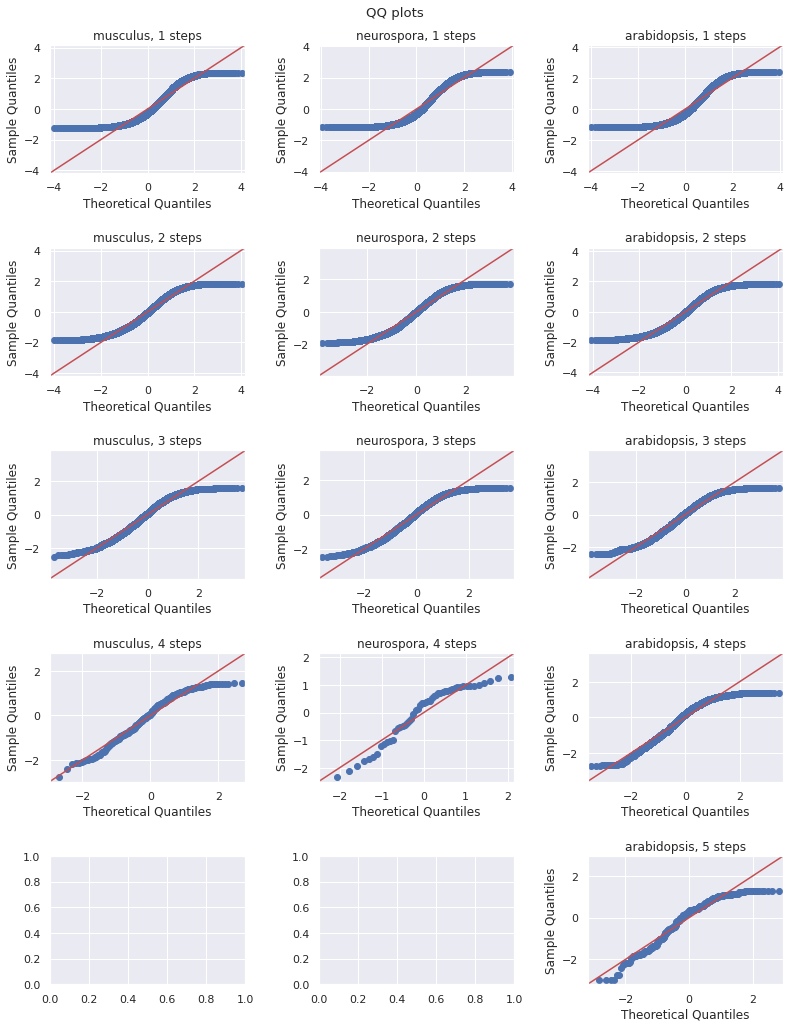

In [90]:
fig, axes = plt.subplots(5, 3, figsize=(12,15))
fig.suptitle('QQ plots')
model = 'classical walk'

for i in [1,2,3]:
  gspace = names[i]
  for step in [1,2,3,4,5]:
    if step == 5 and gspace != 'arabidopsis':
      continue

    axes[step-1][i-1].set_title(f"{gspace}, {step} steps")

    mq = df_phen[gspace][step][model].mean()
    sdq = df_phen[gspace][step][model].std()

    htqw_stand = (df_phen[gspace][step][model] - mq)/sdq

    sm.qqplot(htqw_stand, line ='45', ax=axes[step-1][i-1])

plt.tight_layout(pad=4, w_pad=2, h_pad=2)
#plt.savefig("simulations_results.png")

Testing exponential distribution

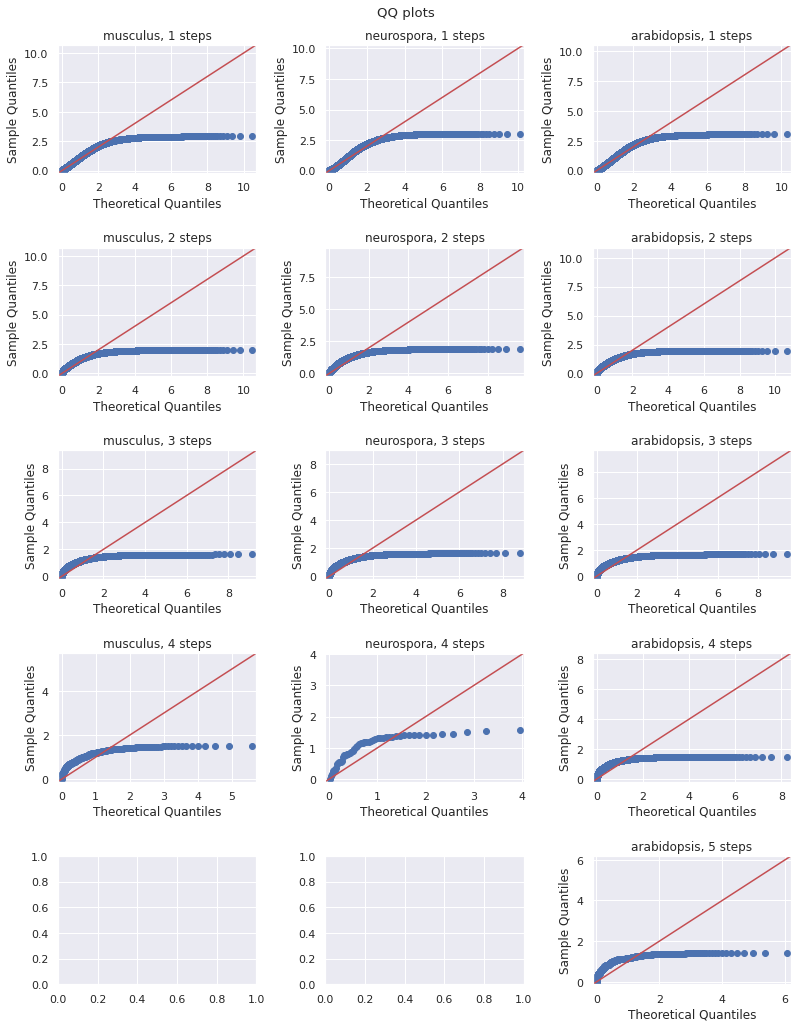

In [91]:
fig, axes = plt.subplots(5, 3, figsize=(12,15))
fig.suptitle('QQ plots')
model = 'classical walk'

for i in [1,2,3]:
  gspace = names[i]
  for step in [1,2,3,4,5]:
    if step == 5 and gspace != 'arabidopsis':
      continue

    axes[step-1][i-1].set_title(f"{gspace}, {step} steps")

    mq = df_phen[gspace][step][model].mean()

    sm.qqplot(df_phen[gspace][step][model], line ='45', ax=axes[step-1][i-1], dist = stats.expon, fit=True)

plt.tight_layout(pad=4, w_pad=2, h_pad=2)
#plt.savefig("simulations_results.png")